## More mocks for M(z=0) :

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import importlib
plt.style.use('./Notebook.mystyle')

Write the random lmap and peaks to get the descendants for :

In [2]:
def write_random_fields():    
    from LATIS.codes import minima
    for n in range(1,21):
        lmap_mock = h5py.File('./thresh/n'+str(n)+'/labeled_map_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')['map'][:]
        peaks = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')
        minima.displace_randomly(lmap_mock, peaks, save_lmap='./thresh/n'+str(n)+'/labeled_map_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00_rnd.hdf5',
                                save_peaks='./thresh/n'+str(n)+'/peaks_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00_rnd.hdf5',
                                seed=125)

In [49]:
def get_ind_non_overlapping(lmap1, lmap2):
    """Returns the indices in the lmap1 which overlap with no satershed in lmap2"""
    ind = np.where(lmap2!=0)
    id_overlapping = np.unique(lmap1[ind])[1:]
    id_non_overlapping = np.unique(lmap1)[1:][np.isin(np.unique(lmap1)[1:], id_overlapping, invert=True)]
    
    return id_overlapping.astype(int) - 1, id_non_overlapping.astype(int) - 1

def read_files(n, z, th, lc, conversion_not_adjusted):
    if conversion_not_adjusted:
        fname = './halos/descendants/Mass_voted_FOF_halos_z'+str(z)+'_n'+str(n)+'_sigma4_th'+th+'_halos_lc'+lc+'_conversion_not_adjusted.hdf5'
        pname = './thresh/n'+str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)+'_sigma4_th'+th+'_lc'+lc+'_conversion_not_adjusted.hdf5'
    else:
        fname = './halos/descendants/Mass_voted_FOF_halos_z'+str(z)+'_n'+str(n)+'_sigma4_th'+th+'_halos_lc'+lc+'.hdf5'
        pname = './thresh/n'+str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)+'_sigma4_th'+th+'_lc'+lc+'.hdf5'
    f = h5py.File(fname,'r')
    peaks = h5py.File(pname,'r')
    #print(fname)
    #print(pname)
    
    return f, peaks
    
def get_Mtomo_GroupMass_true(n=1, th=2.35, lc=2.0, offset=0.114, z=2.4, conversion_not_adjusted=False):
    
    lc=str(lc).ljust(4,'0')
    th = str(th).ljust(4,'0')
    f = h5py.File('./halos/descendants/Mass_voted_FOF_halos_true_z'+str(z)+'_n1_sigma4_th'+th+'_halos_lc'+lc+'.hdf5','r')
    peaks = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_true_z'+str(z)+'_n'+str(n)+'_sigma4_th'+th+'_lc'+lc+'.hdf5','r')
    GroupMass = 10+np.log10(f['GroupMass'][:])
    ind = f['peak_id'][:].astype(int)-1
    Mtomo = peaks['mtomo'][:][ind] + offset
    
    return Mtomo, GroupMass, 0

def get_Mtomo_GroupMass_true_sigma2(n, offset=0.114, z=2.4, conversion_not_adjusted=False):
    f = h5py.File('./halos/descendants/Mass_voted_FOF_halos_true_z2.4_n'+str(n)+'_sigma2_th2.75_halos_lc2.30.hdf5','r')
    peaks = h5py.File('./thresh/n1/peaks_TNG_true_z2.4_n'+str(n)+'_sigma2_th2.75_lc2.30.hdf5','r')
    GroupMass = 10+np.log10(f['GroupMass'][:])
    ind = f['peak_id'][:].astype(int)-1
    Mtomo = peaks['mtomo'][:][ind] + offset
    
    return Mtomo, GroupMass, 0

def get_Mtomo_GroupMass(n, conversion_not_adjusted, z=2.4, th=2.35, lc=2.0, offset=0.114):
    
    lc=str(lc).ljust(4,'0')
    th = str(th).ljust(4,'0')
    f, peaks = read_files(n=n, z=z,th=th, lc=lc, conversion_not_adjusted=conversion_not_adjusted)
    GroupMass = 10+np.log10(f['GroupMass'][:])
    ind = f['peak_id'][:].astype(int)-1
    Mtomo = peaks['mtomo'][:][ind] + offset
    signif = peaks['signif'][ind]
    
    return Mtomo, GroupMass, signif

def get_Mtomo_GroupMass_sigma2(n, z=2.4, offset=0.114, conversion_not_adjusted=False):
    f = h5py.File('./halos/descendants/Mass_voted_FOF_halos_z2.4_n'+str(n)+'_sigma2_th2.75_halos_lc2.30.hdf5','r')
    peaks = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z2.4_n'+str(n)+'_sigma2_th2.75_lc2.30.hdf5','r')
    GroupMass = 10+np.log10(f['GroupMass'][:])
    ind = f['peak_id'][:].astype(int)-1
    Mtomo = peaks['mtomo'][:][ind] + offset
    signif = peaks['signif'][ind]
    
    return Mtomo, GroupMass, signif

def get_Mtomo_GroupMass_random(n, offset=0.114, z=2.4, conversion_not_adjusted=False):
    if z==2.4:
        lc=str(2.00).ljust(4,'0')
        th = str(2.35).ljust(4,'0')
    if z==2.3:
        lc=str(2.35).ljust(4,'0')
        th=str(2.75).ljust(4,'0')
    if z==2.6:
        lc=str(1.90).ljust(4,'0')
        th=str(2.40).ljust(4,'0')
        
    f = h5py.File('./halos/descendants/Mass_voted_FOF_halos_z'+str(z)+'_n'+str(n)+'_sigma4_th'+th+'_halos_lc'+lc+'_rnd.hdf5','r')
    peaks = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)+'_sigma4_th'+th+'_lc'+lc+'_rnd.hdf5','r')
    GroupMass = 10+np.log10(f['GroupMass'][:])
    ind = f['peak_id'][:].astype(int)-1
    Mtomo = peaks['mtomo'][:][ind] + offset
    signif = peaks['signif'][ind]
    
    return Mtomo, GroupMass, signif


def get_the_mean_fit(z, conversion_not_adjusted, offset=0.114,  nrange=np.arange(1,17,1), random=False, sigma2=False):
    
    from scipy.stats import linregress
    slopes, intercepts, M1test, M2test = [], [], [], []
    if random:
        get_masses = get_Mtomo_GroupMass_random
    elif sigma2 :
        get_masses = get_Mtomo_GroupMass_sigma2
    
    else:
        get_masses = get_Mtomo_GroupMass
    
    
    for n in nrange:
        M1, M2, _ = get_masses(n=n, z=z, offset=offset, conversion_not_adjusted=conversion_not_adjusted)
        co = linregress(M1 - 14, M2) 
        slopes.append(co[0])
        intercepts.append(co[1])
        
    slope_mean, intercept_mean = np.mean(slopes), np.mean(intercepts)
    
    print('Slope : ', str(slope_mean)[:5]+'+-'+str(np.std(slopes))[:5])
    print('The prefactor : ', str(intercept_mean)[:5]+'+-'+str(np.std(intercepts))[:5])
    #print('The prefactor in our fit : '+str(intercept_mean+14*slope_mean)[:5]+' +- '+ 
    #                                        str(np.sqrt((14*np.std(slopes))**2 + np.std(intercepts)**2))[:5])
    return (slope_mean, intercept_mean)

def _get_err(co, M1, M2, bins=np.array([13, 13.75, 14.25, 14.75, 15.5])):
    
    fit = lambda x : co[0]*(x-14) +co[1]
    err = []
    for i in range(bins.size-1):
        ind = np.where( (M1 > bins[i])*(M1 < bins[i+1]))
        dev = fit(M1[ind]) - M2[ind]
        err.append(np.sqrt(np.sum(dev*dev)/dev.size))
    return np.array(err)


def test_fit(co, conversion_not_adjusted, z=2.4, offset=0.114, ntest=np.arange(17,21), bins= np.array([13, 14, 14.25, 14.75, 15.5]), random=False, sigma2=False):
    """Find the errors for in mass bins of bins for the mock maps array of ntest"""
    
    if random:
        get_masses = get_Mtomo_GroupMass_random
    elif not sigma2:
        get_masses = get_Mtomo_GroupMass
    else:
        get_masses = get_Mtomo_GroupMass_sigma2

    errall = np.zeros(shape=(ntest.size, bins.size-1))
    for i, n in enumerate(ntest):
        M1, M2, _ = get_masses(n, z=z, offset=offset, conversion_not_adjusted=conversion_not_adjusted)
        errall[i,:] = _get_err(co, M1, M2, bins)
   
    return bins, errall

def get_kde(M1, M2, minmax=(13,16,10,16)):

    from scipy.stats import gaussian_kde as gkde
    
    data = np.zeros((2,M1.size))
    data[0,:] = M1
    data[1,:] = M2

    kernel = gkde(data)  
    X, Y = np.mgrid[minmax[0]:minmax[1]:80j, minmax[2]:minmax[3]:160j]
    grid_points = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(grid_points).T, X.shape)
    del X, Y
    
    return Z


def get_mean_KDE(Mtomo_func, conversion_not_adjusted, offset=0.114,  z=2.4, nmocks=20):
    
    Zall = []
    for n in np.arange(1,nmocks+1):
        Mtomo, GroupMass, _ = Mtomo_func(n=n, z=z, offset=offset, conversion_not_adjusted=conversion_not_adjusted)
        Zall.append(get_kde(Mtomo, GroupMass))

    Zmean = np.zeros(shape=(80,160))
    for Z in Zall:
        Zmean += Z
    Zmean /= nmocks
    
    return Zmean
        

In [9]:
m1 , _ , _ = get_Mtomo_GroupMass(n=1)
m1t, _, _ = get_Mtomo_GroupMass_true()
print(np.min(m1), np.min(m1t))

13.261528008720925 13.650666556179806


In [10]:
get_the_mean_fit(random=False)

Slope :  0.720+-0.090
The prefactor :  13.76+-0.051


(0.720462245111491, 13.76475009105546)

In [11]:
get_the_mean_fit(random=True)

Slope :  0.745+-0.079
The prefactor :  12.53+-0.061


(0.7455556800836272, 12.539063161712718)

In [50]:
def scatter_hist(n, fig, ax, ax_histx, ax_histy, ax_err, ax_err_label, offset, conversion_not_adjusted, z=2.4, bin_size=0.4, plot_kde=False,
                 plot_sigma2=False, plot_noiseless=True, bins_err=np.array([13.3,14.0,14.5,15.0,15.5])):
    import matplotlib
    if plot_sigma2 :
        vmax=0.6
        Mtomo_func = get_Mtomo_GroupMass_sigma2
        Mtomo, GroupMass, signif = get_Mtomo_GroupMass_sigma2(n=n, offset=offset)
        print('Number of watersheds = ', Mtomo.size)
        Mtomo_noiseless, GroupMass_noiseless, _ = get_Mtomo_GroupMass_true_sigma2(n, offset=offset)
        edgecolor='w'
        extent = [13, 16, 10, 16]
        lmap4 = h5py.File('./thresh/n'+str(n)+'/labeled_map_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')['map'][:]
        lmap2 = h5py.File('./thresh/n'+str(n)+'/labeled_map_TNG_z2.4_n'+str(n)+'_sigma2_th3.00_lc2.45.hdf5','r')['map'][:]
        ind_overlapping, ind_non_overlapping = get_ind_non_overlapping(lmap2, lmap4)
        #print(ind_non_overlapping)
        err_yticks = np.arange(0.3,1.0,0.1)
        
    else:
        vmax=0.8
        Mtomo_func = get_Mtomo_GroupMass
        edgecolor='w'
        Mtomo, GroupMass, signif = get_Mtomo_GroupMass(n=n, z=z, offset=offset, conversion_not_adjusted=conversion_not_adjusted)
        print('Number of watersheds = ', Mtomo.size)
        ind_overlapping = np.ones_like(Mtomo, dtype=bool)
        ind_non_overlapping = np.zeros_like(Mtomo, dtype=bool)
        if plot_noiseless:
            Mtomo_noiseless, GroupMass_noiseless, _ = get_Mtomo_GroupMass_true(n=n, z=z, offset=offset)
        extent = [13, 16, 10, 16]
        err_yticks = np.arange(0.3,0.65,0.05)
    
    if plot_kde :
        legendcolor='w'
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        Zmean = get_mean_KDE(Mtomo_func=Mtomo_func, conversion_not_adjusted=conversion_not_adjusted, z=z, offset=offset)
        
        im = ax.imshow(np.rot90(Zmean), cmap=plt.cm.viridis, extent = extent, aspect='auto', vmin=0, vmax=vmax)
        if plot_sigma2 :
            axins = inset_axes(ax,width="100%", height="100%",  bbox_to_anchor=(0.98,0.3, 0.02, 0.6), bbox_transform=ax.transAxes)
            cb_ticks_pos = 'left'
        else:
            axins = inset_axes(ax,width="100%", height="100%",  bbox_to_anchor=(0.05,0.05, 0.02, 0.6), bbox_transform=ax.transAxes)
            cb_ticks_pos = 'right'
        cb = fig.colorbar(im, cax=axins, orientation='vertical', ticks=np.arange(0,vmax+vmax+0.1,0.2))
        cb.ax.yaxis.set_tick_params(color='k')
        cb.ax.yaxis.set_ticks_position(cb_ticks_pos)
        cb.ax.yaxis.set_label_position(cb_ticks_pos)
        plt.setp(plt.getp(axins, 'yticklabels'), color=legendcolor)
        cb.ax.set_ylabel('Gaussian KDE', labelpad=5, color=legendcolor, fontsize=20)

    ind1 = (signif[ind_overlapping] > -2.5)*(signif[ind_overlapping] < -2.0)
    ind2 = (signif[ind_overlapping] > -3.0)*(signif[ind_overlapping] < -2.5)
    ind3 = (signif[ind_overlapping] > -3.5)*(signif[ind_overlapping] < -3.0)
    ind4 = (signif[ind_overlapping] < -3.5)

    with plt.rc_context({'scatter.marker':'o', 'patch.facecolor':'None', 'lines.markersize':'5', 'font.family':'serif'}) :
        if not plot_sigma2:
            ax.scatter(Mtomo[ind_overlapping][ind1], GroupMass[ind_overlapping][ind1], label=r'$-2.5 < \rm \delta_F / \sigma_{map} < -2.35$',edgecolors='r', facecolor='None', alpha=0.65 ,marker='D', lw=3, s=50)
            ax.scatter(Mtomo[ind_overlapping][ind2], GroupMass[ind_overlapping][ind2], label=r'$-3.0 < \rm \delta_F / \sigma_{map} < -2.5$',edgecolors='C1', facecolor='None', alpha=0.65, marker='s', lw=3, s=50)
        else:
            ax.scatter(Mtomo[ind_non_overlapping], GroupMass[ind_non_overlapping], label='New watersheds',edgecolors='C1', facecolor='none', alpha=0.8, marker='*', lw=3, s=50)
        ax.scatter(Mtomo[ind_overlapping][ind3], GroupMass[ind_overlapping][ind3], label=r'$-3.5 < \rm \delta_F / \sigma_{map} < -3.0$',edgecolors='b', facecolor='None', alpha=0.65, marker='o', lw=3, s=50)
        ax.scatter(Mtomo[ind_overlapping][ind4], GroupMass[ind_overlapping][ind4], label=r'$ \ \rm \delta_F / \sigma_{map} < -3.5$',edgecolors=edgecolor, facecolor='none', alpha=0.6, marker='D', lw=3, s=50)
        
        
        ax.plot(np.arange(13,16.5),np.arange(13,16.5), label='1:1', color='r', alpha=0.6, ls='--')


        ax.set_xlim(13.0,15.5)
        ax.set_ylim(10,15.5)
        ax_err.set_xlim(13.0,15.5)
        ax.set_yticks(ticks= np.arange(10.5,15.5,0.5))
        ax.set_xticks(ticks=[])
        ax.set_ylabel('log'+r'$ \rm \left(\  M_{desc} (h^{-1} M_{\odot})\right) $', fontsize=30)


        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20, rotation=20)
        ax.tick_params(axis="x", labelbottom=False)
        ax.grid(True, alpha=0.7)
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)
        ax_histx.set_ylabel('count')
        ax_histy.set_xlabel('count')

        co = get_the_mean_fit(z=z, offset=offset, sigma2=plot_sigma2, conversion_not_adjusted=conversion_not_adjusted)
        
        #co_rand = get_the_mean_fit(random=True)
        #Mfit_rand = co_rand[0]*x + co_rand[1]
        #ax.plot(x, Mfit_rand, label='random')
        
        bins = np.arange(np.min(Mtomo), np.max(Mtomo)+2*bin_size,bin_size)
        ax_histx.hist(Mtomo, bins=bins, histtype='step', color='C0')
        plt.setp(ax_histx.get_yticklabels(), fontsize=20)
        
        bins = np.arange(np.min(GroupMass), np.max(GroupMass)+2*bin_size,bin_size)
        ax_histy.hist(GroupMass, bins=bins, histtype='step', label='Detected \n Watersheds', color='C0', orientation='horizontal')
        
        if not plot_sigma2:
            M1, M2, _ = get_Mtomo_GroupMass_random(n)
            bins = np.arange(np.min(M2), np.max(M2)+2*bin_size,bin_size)
            ax_histy.hist(M2, bins=bins, histtype='step', label='random \n watersheds', color='C1', orientation='horizontal', ls='--')
        else :
            bins = np.arange(np.min(GroupMass), np.max(GroupMass)+2*bin_size,bin_size)
            ax_histy.hist(GroupMass[ind_non_overlapping], bins=bins, histtype='step', label="Detected \n only in \n this map", color='C1', orientation='horizontal', ls='--')
         
        plt.setp(ax_histy.get_xticklabels(), fontsize=20)
        ax_histy.set_xticks(ticks = np.arange(10,75, 20))
        ax_histx.grid(True, alpha=0.7)
        ax_histy.grid(True, alpha=0.7)
        ax_histy.legend(loc=(0,0.01), fontsize=17, frameon=False)
        def _plot_uncertainty_M0_paper(ax_err):                    
            with plt.rc_context({'scatter.marker':'o', 'patch.facecolor':'k', 'lines.markersize':'7', 'font.family':'serif'}) :
                
                #bins = np.arange(np.min(Mtomo),np.max(Mtomo)+bin_size+0.05,bin_size)
                #bins = np.delete(bins, -2)
                mbin = np.array([(bins_err[b]+bins_err[b+1])/2 for b in range(0, bins_err.size-1)])
                _ , err = test_fit(co=co, conversion_not_adjusted=conversion_not_adjusted, z=z, offset=offset, bins=bins_err, sigma2=plot_sigma2)
                ax_err.errorbar(x=mbin, y=np.mean(err, axis=0), yerr=np.std(err, axis=0), marker='o', label=ax_err_label,  markersize=10)
                
                Mfit = co[0]*(mbin-14) + co[1]

                ax.plot(mbin, Mfit, label='power-law estimator', color='k', alpha=0.5)
                
                from scipy.stats import linregress
                if plot_noiseless:
                    co_noiseless = linregress(Mtomo_noiseless-14, GroupMass_noiseless)
                    bins_noiseless = np.arange(np.min(Mtomo_noiseless),np.max(Mtomo_noiseless)+bin_size,bin_size)
                    bins_noiseless = np.delete(bins_noiseless, -2)
                    mbin_noiseless = np.array([(bins_noiseless[b]+bins_noiseless[b+1])/2 for b in range(0, bins_noiseless.size-1)])

                    err_true = _get_err(co_noiseless, Mtomo_noiseless, GroupMass_noiseless, bins_noiseless)
                    ax_err.plot(mbin_noiseless, err_true, marker='s', ls='--', label='Noiseless', color='C2')
                
                #ax_err.legend(framealpha=0, loc=(0.02,0.15))
                ax_err.legend(framealpha=0, loc='upper right')

                ax_err.set_xlabel('log'+ r'$\ \rm \left( M_{tomo} (h^{-1} M_{\odot})\right) $', fontsize=30)
                ax_err.set_ylabel('error on '+r'$\rm M_{desc}$'+'(dex)', fontsize=25)
                
                ax.legend(fontsize=20, loc='lower right', framealpha=0,  labelcolor=legendcolor)

                
                ax_err.set_yticks(ticks= err_yticks)
                ax_err.set_xticks(ticks= np.arange(13.5,15.5,0.5))
                if not plot_sigma2:
                    ax_err.set_ylim((0.20,0.65))
                    
                plt.setp(ax_err.get_xticklabels(), rotation=20, fontsize=20)
                plt.setp(ax_err.get_yticklabels(), rotation=20, fontsize=20)
                ax_err.grid(True, alpha=0.7)


        _plot_uncertainty_M0_paper(ax_err)


Number of watersheds =  225
Slope :  0.720+-0.090
The prefactor :  13.76+-0.052


<ipython-input-51-1a8c4875820f>:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


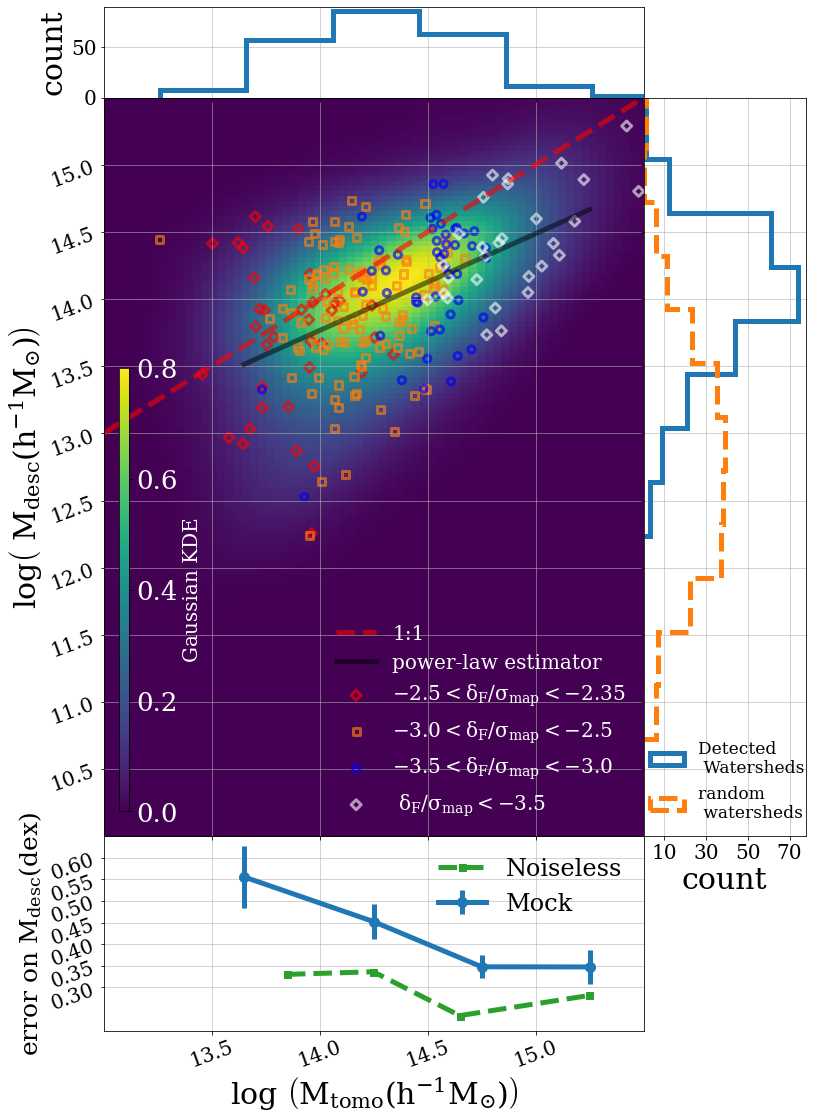

In [51]:
# definitions for the axes
left, width = 0.3, 0.5
bottom, height = 0.3, 0.57

rect_scatter = [left, bottom, width, height]
rect_err = [left, bottom - 0.15 ,width, 0.15]
rect_histx = [left, bottom + height, width, 0.07]
rect_histy = [left + width , bottom, 0.15, height]

# start with a square Figure
fig_mock = plt.figure(figsize=(15, 18))
#fig_rand, ax_rand = plt.subplots(1,1,figsize=(10,10))

ax_err_mock = fig_mock.add_axes(rect_err)
ax = fig_mock.add_axes(rect_scatter, sharex=ax_err_mock)
ax_histx = fig_mock.add_axes(rect_histx, sharex=ax)
ax_histy = fig_mock.add_axes(rect_histy, sharey=ax)

scatter_hist(n=1, fig=fig_mock, ax=ax, ax_histx=ax_histx, ax_histy=ax_histy, ax_err = ax_err_mock, ax_err_label='Mock', offset=0.114,
             conversion_not_adjusted=False, plot_kde=True, plot_sigma2=False)
plt.tight_layout()
fig_mock.savefig('M0_Mtomo_scatter_sigma4.pdf', transparent=False)

$\sigma = 2$:

Number of watersheds =  639
Slope :  1.110+-0.065
The prefactor :  13.94+-0.027


<ipython-input-53-c2fba49a6ecb>:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


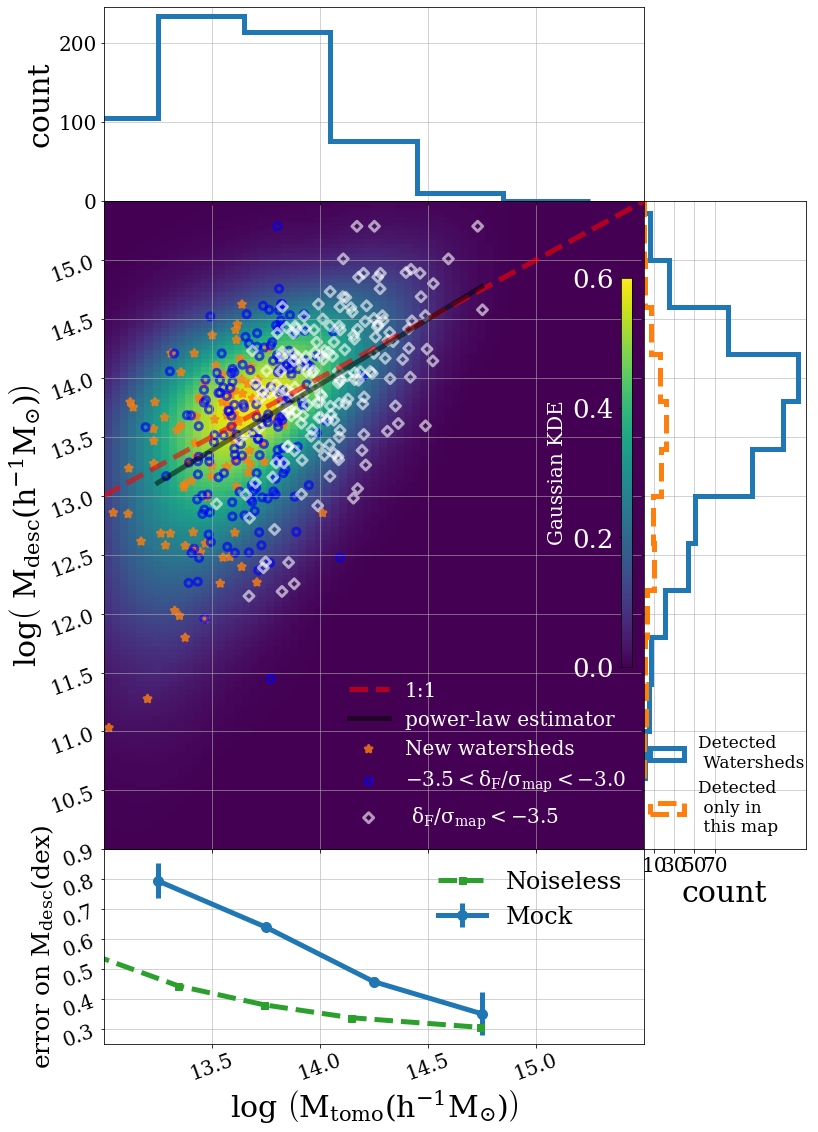

In [53]:
# definitions for the axes
left, width = 0.3, 0.5
bottom, height = 0.3, 0.5

rect_scatter = [left, bottom, width, height]
rect_err = [left, bottom - 0.15 ,width, 0.15]
rect_histx = [left, bottom + height, width, 0.15]
rect_histy = [left + width , bottom, 0.15, height]

# start with a square Figure
fig_mock = plt.figure(figsize=(15, 18))
#fig_rand, ax_rand = plt.subplots(1,1,figsize=(10,10))

ax_err_mock = fig_mock.add_axes(rect_err)
ax = fig_mock.add_axes(rect_scatter, sharex=ax_err_mock)
ax_histx = fig_mock.add_axes(rect_histx, sharex=ax)
ax_histy = fig_mock.add_axes(rect_histy, sharey=ax)

scatter_hist(n=1, fig=fig_mock, ax=ax, ax_histx=ax_histx, ax_histy=ax_histy, ax_err = ax_err_mock, ax_err_label='Mock', 
             offset=0.114, conversion_not_adjusted=False, plot_kde=True, plot_sigma2=True, bins_err=np.array([13,13.5,14,14.5,15]))
plt.tight_layout()
fig_mock.savefig('M0_Mtomo_scatter_sigma2.pdf')

In [203]:
def get_mean_err_sigma2_sigma4(nmocks=20,  co_sig2=[0.72, 13.8], co_sig4=(1.11,13.9)):
    
    bins = np.array([13,13.5,14,14.5,15,15.5,16])
    mbins = np.array([(bins[b]+bins[b+1])/2 for b in range(bins.size-1)])
    dev_bins_all = [np.empty((nmocks, mbins.size)), np.empty((nmocks, mbins.size))]
    print(dev_bins_all[0].shape)
    
    for i, n in enumerate(np.arange(1, nmocks+1)):
        fdesc1 = h5py.File('./halos/descendants/Mass_voted_FOF_halos_z2.4_n'+str(n)+'_sigma2_th2.75_halos_lc2.30.hdf5','r')
        fdesc2 = h5py.File('./halos/descendants/Mass_voted_FOF_halos_z2.4_n'+str(n)+'_sigma4_th2.35_halos_lc2.00.hdf5','r')
        peaks_mock1 = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z2.4_n'+str(n)+'_sigma2_th2.75_lc2.30.hdf5','r')
        peaks_mock2 = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')
        ind1 = fdesc1['peak_id'][:].astype(int)-1
        ind2 = fdesc2['peak_id'][:].astype(int)-1
        Mtomo = [peaks_mock1['mtomo'][:][ind1], peaks_mock2['mtomo'][:][ind2]] 
        GroupMass = [10+np.log10(fdesc1['GroupMass'][:]), 10+np.log10(fdesc2['GroupMass'][:])]
        Mdesc_est = lambda x, p : (x-14)*p[0] +p[1]
        GroupMassFit = [ Mdesc_est(Mtomo[0], co_sig2), Mdesc_est(Mtomo[1], co_sig4)]
        #print('sigma = 2 : ', np.min(GroupMassFit[0]),'\t',np.max(GroupMassFit[0]))
        #print('sigma = 4 :',np.min(GroupMassFit[0]),'\t',np.max(GroupMassFit[0]))
        
        for j in range(2):
            dev = GroupMass[j] - GroupMassFit[j]
            for b in range(bins.size-1):
                indp = np.where((GroupMassFit[j]<bins[b+1])*(GroupMassFit[j] > bins[b]))[0].astype(int)
                dev_bins = np.sqrt(np.dot(dev[indp],dev[indp])/indp.size)
                #print(j,i,b)
                dev_bins_all[j][i,b] =  dev_bins
            
    return np.median(dev_bins_all[0], axis=0), np.median(dev_bins_all[1], axis=0), np.std(dev_bins_all[0], axis=0), np.std(dev_bins_all[1], axis=0), mbins, bins
    
def plot_uncertainty_M0_paper_sigma(ax):
    plt.style.use('Notebook.mystyle')
    plt.rc('font', family='Serif')
    sigma = [2, 4]
    color = ['C1','C2']
    ls = [('solid','dotted'), ('dashed', '-.')]
    
    
    dev_bins2, dev_bins4, std2, std4, mbins, bins = get_mean_err_sigma2_sigma4()
    ind = np.where(dev_bins2 != np.nan)
    ax.errorbar(mbins[ind], dev_bins2[ind], yerr=std2[ind], marker='o', label='$\sigma = 2$', ls='solid', alpha=0.7, capsize=8, capthick=3)
    ind = np.where(dev_bins4 != np.nan)
    ax.errorbar(mbins[ind], dev_bins4[ind], yerr=std4[ind], marker='o', label='$\sigma = 4$', ls='dotted', alpha=0.7, capsize=8, capthick=3)
    #ax.plot(mbin, std, marker='*', label='std '+'$\sigma = $'+str(sigma[i]), ls=ls[i][1],color=color[i], alpha=0.7)
    ax.set_xlabel(r'$\mathrm{log[\ M_{desc}^{est} (h^{-1} M_{\odot})] }$', fontsize=30)
    ax.set_ylabel('RMS error on '+r'$\mathrm{M_{desc} \ (dex)}$', fontsize=34)
    ax.legend(fontsize=30, frameon=False)
    ax.set_xlim(13,15)
    ax.set_ylim(0, 1)
    plt.setp(ax.get_xticklabels(), rotation=20, fontsize=30)
    plt.setp(ax.get_yticklabels(), fontsize=30)
    plt.grid(True)


In [175]:
get_mean_err_sigma2_sigma4()

(20, 6)


<ipython-input-174-282c5fa60c9c>:26: RuntimeWarning: invalid value encountered in double_scalars
  dev_bins = np.sqrt(np.dot(dev[indp],dev[indp])/indp.size)


(array([0.73828346, 0.60308137, 0.60137744,        nan,        nan,
               nan]),
 array([0.67025085, 0.493841  , 0.38956344, 0.4214803 ,        nan,
               nan]),
 array([0.03280915, 0.01812896, 0.08438867,        nan,        nan,
               nan]),
 array([0.06500691, 0.0333496 , 0.03358999, 0.05595579,        nan,
               nan]),
 array([13.25, 13.75, 14.25, 14.75, 15.25, 15.75]),
 array([13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ]))

(20, 6)


<ipython-input-203-3b9e6b32c947>:26: RuntimeWarning: invalid value encountered in double_scalars
  dev_bins = np.sqrt(np.dot(dev[indp],dev[indp])/indp.size)


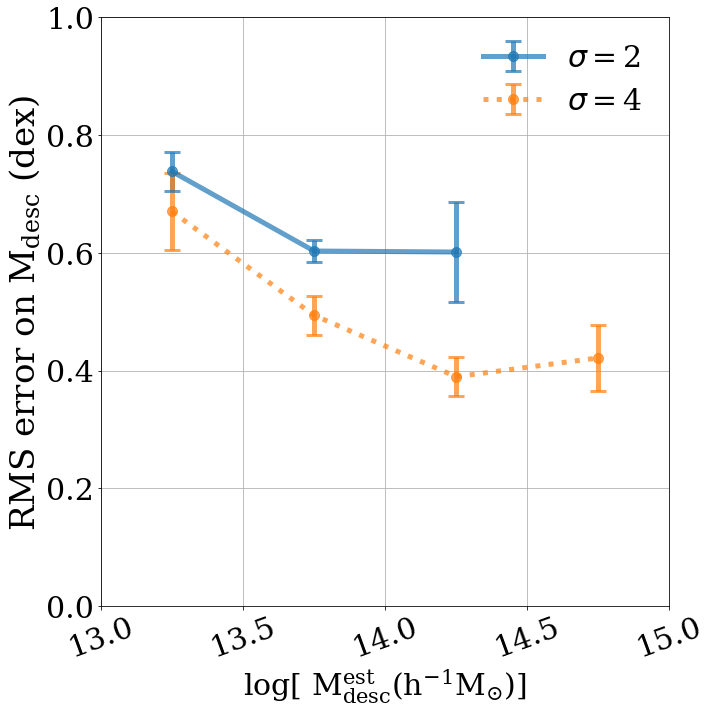

In [204]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_uncertainty_M0_paper_sigma(ax)
plt.tight_layout()
plt.savefig('M0_Mtomo_sigma_err_M0fit.pdf',transparent=True)

z=2.3:

if we use $\delta_F$-vs-$\rho_{DM}$ for that particular redshift.

Number of watersheds =  189
Slope :  0.759+-0.092
The prefactor :  13.74+-0.051


<ipython-input-54-62471ea90305>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


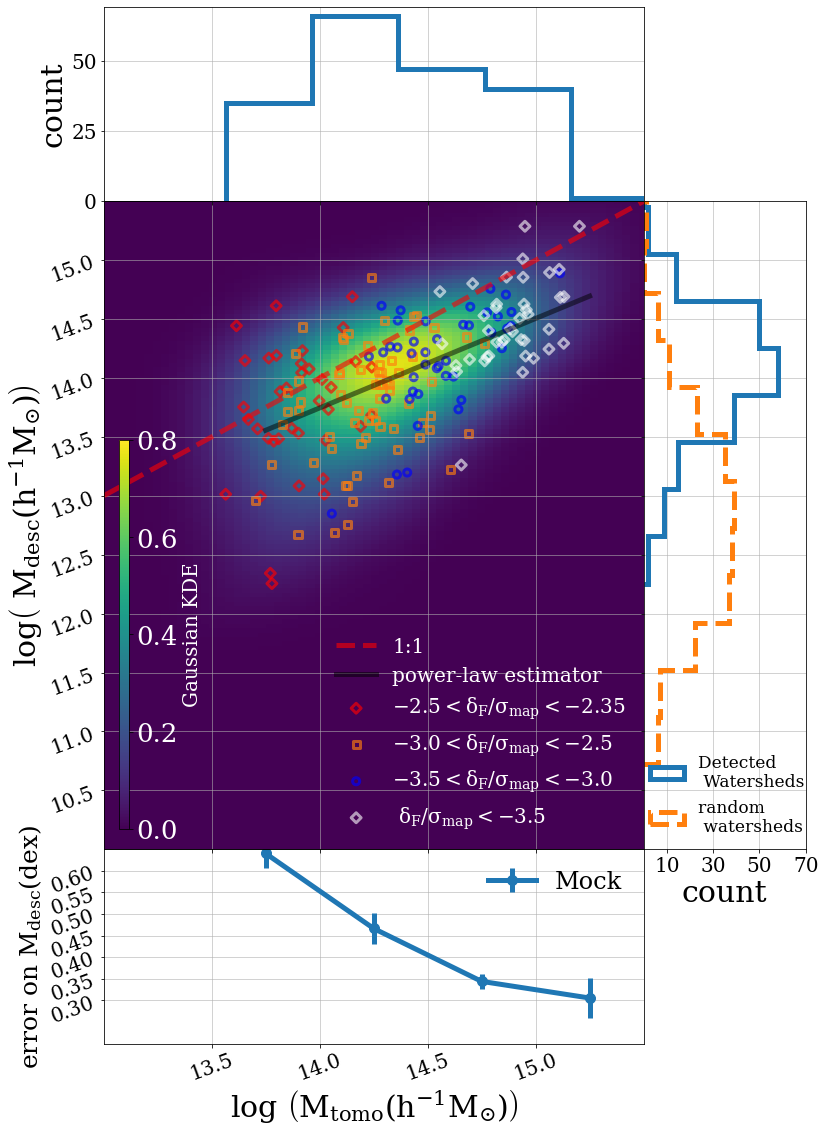

In [54]:
# definitions for the axes
left, width = 0.3, 0.5
bottom, height = 0.3, 0.5

rect_scatter = [left, bottom, width, height]
rect_err = [left, bottom - 0.15 ,width, 0.15]
rect_histx = [left, bottom + height, width, 0.15]
rect_histy = [left + width , bottom, 0.15, height]

# start with a square Figure
fig_mock = plt.figure(figsize=(15, 18))
#fig_rand, ax_rand = plt.subplots(1,1,figsize=(10,10))

ax_err_mock = fig_mock.add_axes(rect_err)
ax = fig_mock.add_axes(rect_scatter, sharex=ax_err_mock)
ax_histx = fig_mock.add_axes(rect_histx, sharex=ax)
ax_histy = fig_mock.add_axes(rect_histy, sharey=ax)

scatter_hist(n=1, z=2.3, fig=fig_mock, ax=ax, ax_histx=ax_histx, ax_histy=ax_histy, ax_err = ax_err_mock,
             ax_err_label='Mock', offset=0.114, conversion_not_adjusted=False ,plot_kde=True, plot_sigma2=False, plot_noiseless=False,
            bins_err=np.array([13.5,14,14.5,15,15.5]))
plt.tight_layout()
#fig_mock.savefig('M0_Mtomo_scatter_sigma4.pdf', transparent=True)

if we use $\delta_F$-vs-$\rho_{DM}$ for z=2.4

Number of watersheds =  189
Slope :  0.761+-0.093
The prefactor :  13.76+-0.049


<ipython-input-56-68579d685e7a>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


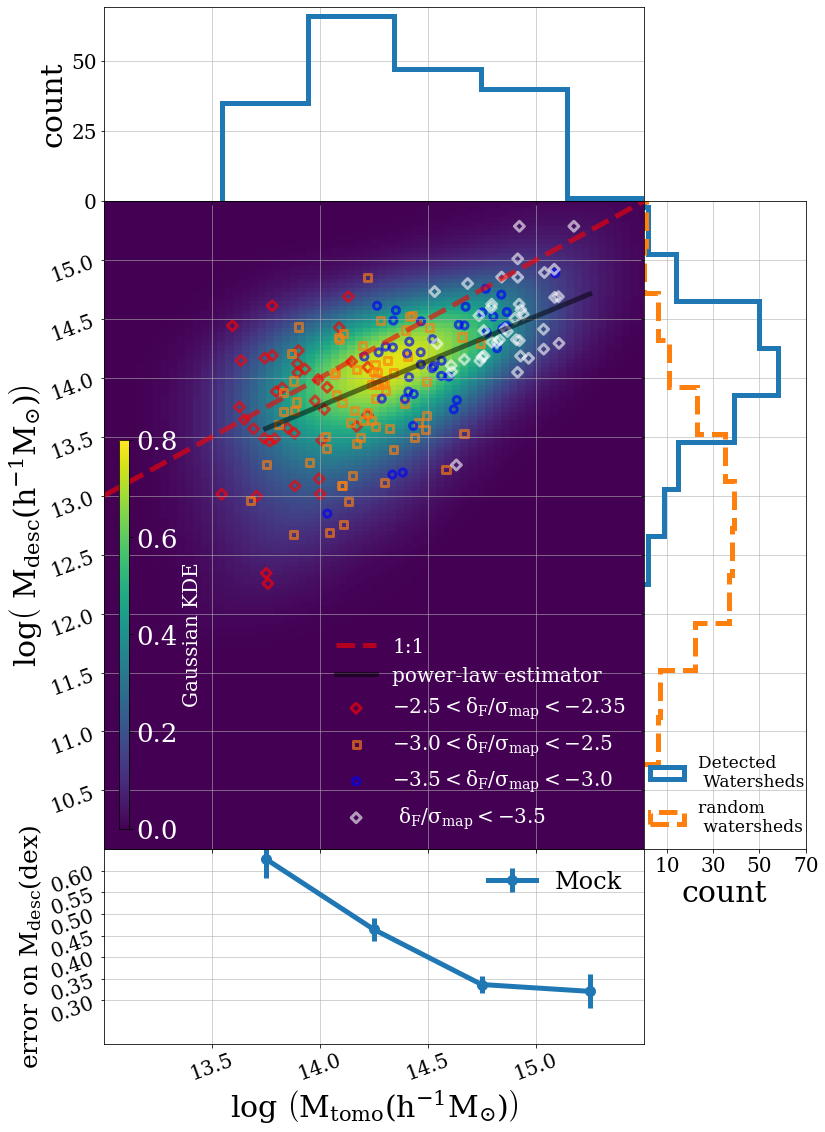

In [56]:
# definitions for the axes
left, width = 0.3, 0.5
bottom, height = 0.3, 0.5

rect_scatter = [left, bottom, width, height]
rect_err = [left, bottom - 0.15 ,width, 0.15]
rect_histx = [left, bottom + height, width, 0.15]
rect_histy = [left + width , bottom, 0.15, height]

# start with a square Figure
fig_mock = plt.figure(figsize=(15, 18))
#fig_rand, ax_rand = plt.subplots(1,1,figsize=(10,10))

ax_err_mock = fig_mock.add_axes(rect_err)
ax = fig_mock.add_axes(rect_scatter, sharex=ax_err_mock)
ax_histx = fig_mock.add_axes(rect_histx, sharex=ax)
ax_histy = fig_mock.add_axes(rect_histy, sharey=ax)

scatter_hist(n=1, z=2.3, fig=fig_mock, ax=ax, ax_histx=ax_histx, ax_histy=ax_histy, ax_err = ax_err_mock,
             ax_err_label='Mock', offset=0.114, conversion_not_adjusted=True ,plot_kde=True, plot_sigma2=False, plot_noiseless=False,
            bins_err=np.array([13.5,14,14.5,15,15.5]))
plt.tight_layout()
#fig_mock.savefig('M0_Mtomo_scatter_sigma4.pdf', transparent=True)

z=2.6:

if we use $\delta_F$-vs-$\rho_{DM}$ for that particular redshift.

Number of watersheds =  212
Slope :  0.769+-0.085
The prefactor :  13.76+-0.041


<ipython-input-57-92a05bc865a8>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


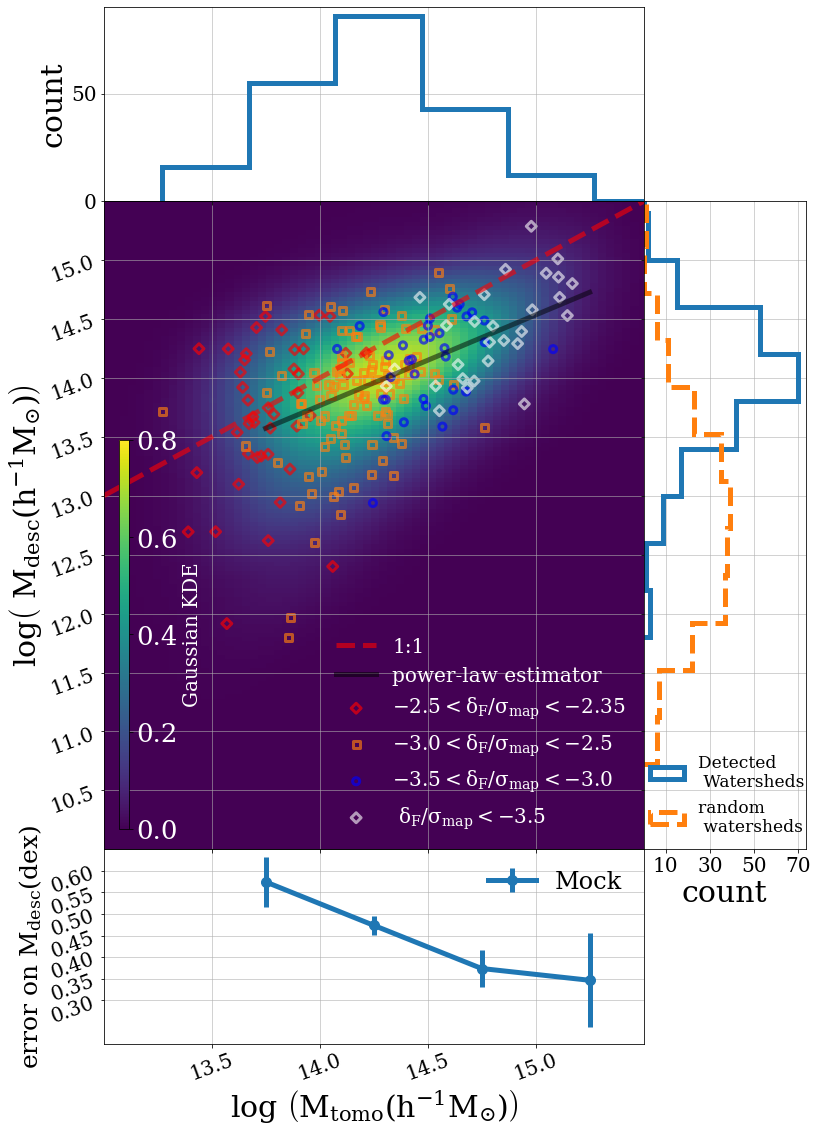

In [57]:
# definitions for the axes
left, width = 0.3, 0.5
bottom, height = 0.3, 0.5

rect_scatter = [left, bottom, width, height]
rect_err = [left, bottom - 0.15 ,width, 0.15]
rect_histx = [left, bottom + height, width, 0.15]
rect_histy = [left + width , bottom, 0.15, height]

# start with a square Figure
fig_mock = plt.figure(figsize=(15, 18))
#fig_rand, ax_rand = plt.subplots(1,1,figsize=(10,10))

ax_err_mock = fig_mock.add_axes(rect_err)
ax = fig_mock.add_axes(rect_scatter, sharex=ax_err_mock)
ax_histx = fig_mock.add_axes(rect_histx, sharex=ax)
ax_histy = fig_mock.add_axes(rect_histy, sharey=ax)

scatter_hist(n=1, z=2.6, fig=fig_mock, ax=ax, ax_histx=ax_histx, ax_histy=ax_histy, ax_err = ax_err_mock,
             ax_err_label='Mock', conversion_not_adjusted=False, offset=0.114, plot_kde=True, plot_sigma2=False, plot_noiseless=False,
            bins_err=np.array([13.5,14,14.5,15,15.5]))
plt.tight_layout()
#fig_mock.savefig('M0_Mtomo_scatter_sigma4.pdf', transparent=True)

if we use $\delta_F$-vs-$\rho_{DM}$ at z=2.45 :

Number of watersheds =  212
Slope :  0.768+-0.084
The prefactor :  13.76+-0.042


<ipython-input-58-cd96ee558982>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


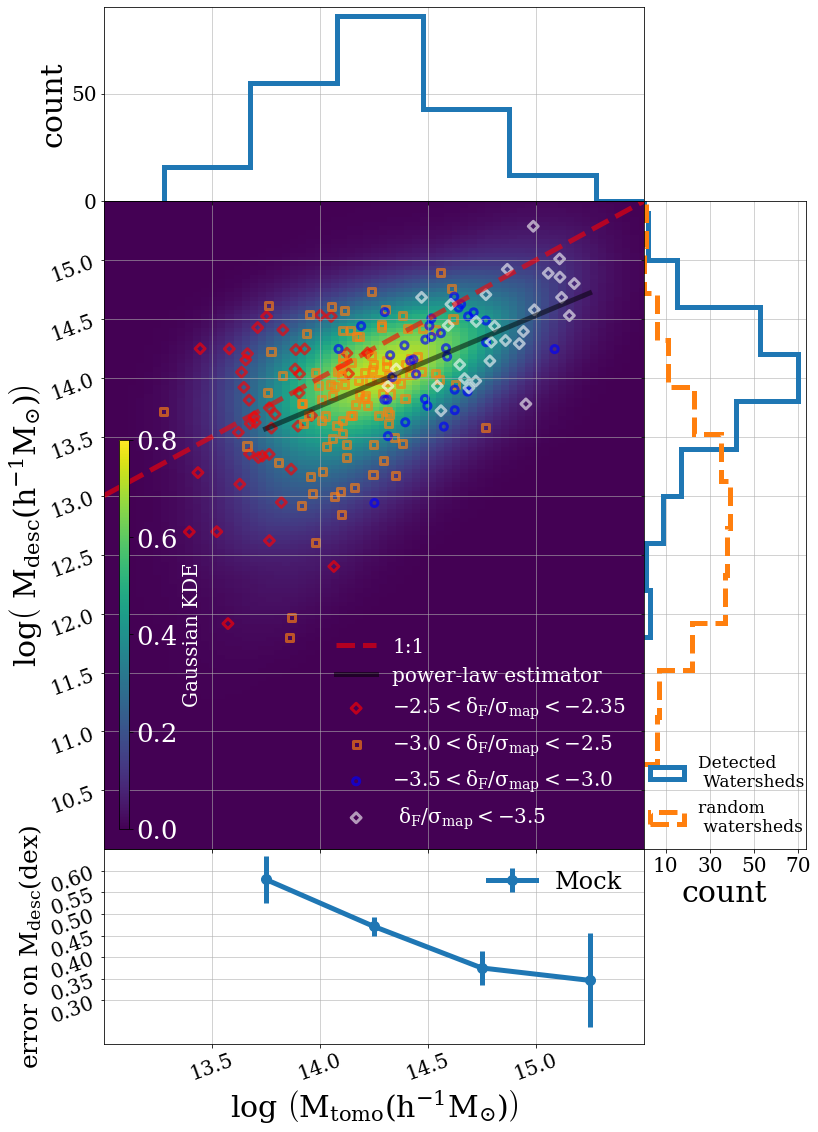

In [58]:
# definitions for the axes
left, width = 0.3, 0.5
bottom, height = 0.3, 0.5

rect_scatter = [left, bottom, width, height]
rect_err = [left, bottom - 0.15 ,width, 0.15]
rect_histx = [left, bottom + height, width, 0.15]
rect_histy = [left + width , bottom, 0.15, height]

# start with a square Figure
fig_mock = plt.figure(figsize=(15, 18))
#fig_rand, ax_rand = plt.subplots(1,1,figsize=(10,10))

ax_err_mock = fig_mock.add_axes(rect_err)
ax = fig_mock.add_axes(rect_scatter, sharex=ax_err_mock)
ax_histx = fig_mock.add_axes(rect_histx, sharex=ax)
ax_histy = fig_mock.add_axes(rect_histy, sharey=ax)

scatter_hist(n=1, z=2.6, fig=fig_mock, ax=ax, ax_histx=ax_histx, ax_histy=ax_histy, ax_err = ax_err_mock,
             ax_err_label='Mock', conversion_not_adjusted=True, offset=0.114, plot_kde=True, plot_sigma2=False, plot_noiseless=False,
            bins_err=np.array([13.5,14,14.5,15,15.5]))
plt.tight_layout()
#fig_mock.savefig('M0_Mtomo_scatter_sigma4.pdf', transparent=True)

Summarizing the redshift differences :

1. Errors in the mass bins are the same.

2. The slopes and intercepts match within the uncertainties. 

|z | # Watersheds | slope | intercept |
|--|--|--| --|
|2.3| --  | 0.76 +-0.09 | 13.74+-0.06|
|2.4| -- | 0.72+-0.09 | 13.76+-0.05|
|2.6| -- | 0.77+-0.09 | 13.76+-0.05|

3. It does not matter whether we use $\delta_F$-vs-$\rho_{DM}$ relation at the midpoint redshift or adjust it for each redshift bin.